# **Shape functions for Bernoulli Beams**

In [27]:
import sympy as sy
from sympy import latex
from sympy.printing.pycode import pycode
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rc('pgf', texsystem='pdflatex')  # or luatex, xelatex...


In [28]:
N = 3
working_dir = "f:\\WORKING\\bernoulli\\"
src_dir = "f:\\GitHub\\dewloosh-solid\\src\\dewloosh\\solid\\fem\\cells\\gen\\"
#scr_dir = working_dir

In [29]:
module_data = {}
src_dir = working_dir if src_dir is None else src_dir
src_path = os.path.join(src_dir, "b{}".format(N))
pgf_tmpl = "shp{}_pgf"
pgf_path = os.path.join(working_dir, pgf_tmpl.format(N))
doc_path = os.path.join(working_dir, "b{}_doc".format(N))


## Lagrange polinomials

In [30]:
def calc_Lagrange(inds, *args, N: int = None, positions=None, **kwargs):
    global module_data
    x = sy.symbols('x')
    N = len(inds)
    def var_tmpl(i): return '\\Delta_{}'.format(i)
    def var_str(i): return var_tmpl(inds[i])
    coeffs = sy.symbols(', '.join(['c_{}'.format(i+1) for i in range(N)]))
    variables = sy.symbols(', '.join([var_str(i) for i in range(N)]))
    if positions is None:
        positions = sy.symbols(
            ', '.join(['x{}'.format(i+1) for i in range(N)]))
    poly = sum([c * x**i for i, c in enumerate(coeffs)])
    #
    evals = [poly.subs({'x': positions[i]}) for i in range(N)]
    A = sy.zeros(N, N)
    for i in range(N):
        A[i, :] = sy.Matrix([evals[i].coeff(c) for c in coeffs]).T
    coeffs_new = A.inv() * sy.Matrix(variables)
    subs = {coeffs[i]: coeffs_new[i] for i in range(N)}
    approx = poly.subs(subs).simplify().expand()
    #
    shp = [approx.coeff(v).factor().simplify() for v in variables]
    #
    def diff(fnc): return fnc.diff(x).expand().simplify().factor().simplify()
    dshp1 = [diff(fnc) for fnc in shp]
    dshp2 = [diff(fnc) for fnc in dshp1]
    dshp3 = [diff(fnc) for fnc in dshp2]
    #
    for i, ind in enumerate(inds):
        module_data[ind] = {}
        fnc_str = latex(sy.symbols('\phi_{}'.format(ind)))
        module_data[ind]['symbol'] = fnc_str
        module_data[ind][0] = shp[i]
        module_data[ind][1] = dshp1[i]
        module_data[ind][2] = dshp2[i]
        module_data[ind][3] = dshp3[i]


## Hermite polinomials

In [31]:
def calc_Hermite(inds, *args, N: int = None, sign=1,
                 positions=None, **kwargs):
    global module_data
    x, L = sy.symbols('x L')
    nC = 2 * N
    def var_tmpl(i): return '\\Delta_{}'.format(i)
    def var_str(i): return var_tmpl(inds[i])
    coeffs = sy.symbols(', '.join(['c_{}'.format(i+1) for i in range(nC)]))
    variables = sy.symbols(', '.join([var_str(i) for i in range(nC)]))
    if positions is None:
        positions = sy.symbols(
            ', '.join(['x{}'.format(i+1) for i in range(N)]))
    poly = sum([c * x**i for i, c in enumerate(coeffs)])
    poly = poly.expand()
    dpoly = sign * poly.diff(x, 1) * 2/L
    dpoly = dpoly.expand()
    #
    evals = [poly.subs({'x': positions[i]}) for i in range(N)]
    devals = [dpoly.subs({'x': positions[i]}) for i in range(N)]
    A = sy.zeros(nC, nC)
    c = 0
    for i in range(N):
        A[c, :] = sy.Matrix([evals[i].coeff(c) for c in coeffs]).T
        A[c + 1, :] = sy.Matrix([devals[i].coeff(c) for c in coeffs]).T
        c += 2
    coeffs_new = A.inv() * sy.Matrix(variables)
    subs = {coeffs[i]: coeffs_new[i] for i in range(2*N)}
    approx = poly.subs(subs).simplify().expand()
    #
    shp = [approx.coeff(v).factor().simplify() for v in variables]
    #
    def diff(fnc): return fnc.diff(x).expand().simplify().factor().simplify()
    dshp1 = [diff(fnc) for fnc in shp]
    dshp2 = [diff(fnc) for fnc in dshp1]
    dshp3 = [diff(fnc) for fnc in dshp2]
    #
    for i, ind in enumerate(inds):
        module_data[ind] = {}
        fnc_str = latex(sy.symbols('\phi_{}'.format(ind)))
        module_data[ind]['symbol'] = fnc_str
        module_data[ind][0] = shp[i]
        module_data[ind][1] = dshp1[i]
        module_data[ind][2] = dshp2[i]
        module_data[ind][3] = dshp3[i]


### Stretching -> $U$

In [32]:
# u_x
inds = [1 + 6*i for i in range(N)]  # start = 1
positions = np.linspace(-1, 1, N)
calc_Lagrange(inds, positions=positions)
print("stored implementations for dofs : {}".format(inds))


stored implementations for dofs : [1, 7, 13]


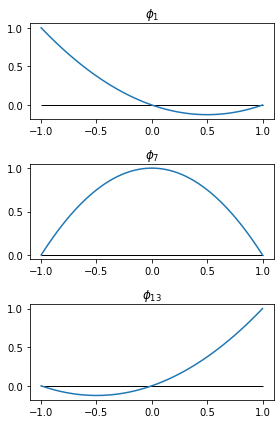

In [33]:
w = 4
h = 2 * len(inds)
fig = plt.figure(figsize=(w, h))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(len(inds), 1)

xdata = np.linspace(-1, 1, 100)

for i, ind in enumerate(inds):
    ax = fig.add_subplot(gs[i])
    label = '$' + module_data[ind]['symbol'] + '$'
    ax.set_title(label)
    fnc = module_data[ind][0].subs({'L': 2})
    shp = sy.lambdify('x', fnc, 'numpy')
    fdata = list(map(shp, xdata))
    ax.plot(xdata, fdata)
    #
    ax.hlines(y=0, xmin=-1, xmax=1, colors='k', zorder=-10, lw=1.0)

fig.tight_layout()


### Twisting -> $\theta_x$

In [34]:
# theta_x
inds = [4 + 6*i for i in range(N)]  # start = 1
positions = np.linspace(-1, 1, N)
calc_Lagrange(inds, positions=positions)
print("stored implementations for dofs : {}".format(inds))


stored implementations for dofs : [4, 10, 16]


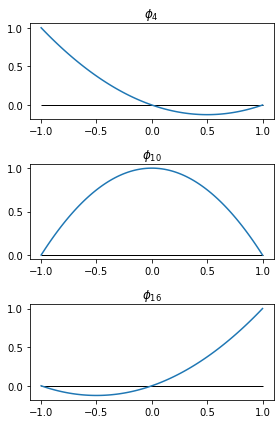

In [35]:
w = 4
h = 2 * len(inds)
fig = plt.figure(figsize=(w, h))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(len(inds), 1)

xdata = np.linspace(-1, 1, 100)

for i, ind in enumerate(inds):
    ax = fig.add_subplot(gs[i])
    label = '$' + module_data[ind]['symbol'] + '$'
    ax.set_title(label)
    fnc = module_data[ind][0].subs({'L': 2})
    shp = sy.lambdify('x', fnc, 'numpy')
    fdata = list(map(shp, xdata))
    ax.plot(xdata, fdata)
    #
    ax.hlines(y=0, xmin=-1, xmax=1, colors='k', zorder=-10, lw=1.0)

fig.tight_layout()


### Bending in the x-y plane -> $v$, $\theta_z$

In [36]:
u, r = [2 + 6*i for i in range(N)], [6 + 6*i for i in range(N)]
inds = np.array(list(zip(u, r))).flatten()
positions = np.linspace(-1, 1, N)
calc_Hermite(inds, positions=positions, N=N, sign=1)
print("stored implementations for dofs : {}".format(inds))


stored implementations for dofs : [ 2  6  8 12 14 18]


In [37]:
module_data[u[0]][0].factor()

1.0*x**2*(0.75*x + 1.0)*(x - 1)**2

In [38]:
module_data[u[1]][0].factor()

1.0*(x - 1)**2*(x + 1)**2

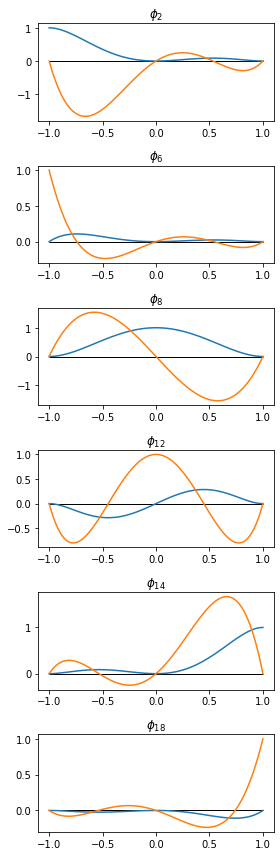

In [39]:
w = 4
h = 2 * len(inds)
fig = plt.figure(figsize=(w, h))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(len(inds), 1)

xdata = np.linspace(-1, 1, 100)

for i, ind in enumerate(inds):
    ax = fig.add_subplot(gs[i])
    label = '$' + module_data[ind]['symbol'] + '$'
    ax.set_title(label)
    # fnc
    fnc = module_data[ind][0].subs({'L': 2})
    shp = sy.lambdify('x', fnc, 'numpy')
    fdata = list(map(shp, xdata))
    ax.plot(xdata, fdata)
    # first derivative
    fnc = module_data[ind][1].subs({'L': 2})
    shp = sy.lambdify('x', fnc, 'numpy')
    fdata = list(map(shp, xdata))
    ax.plot(xdata, fdata)
    #
    ax.hlines(y=0, xmin=-1, xmax=1, colors='k', zorder=-10, lw=1.0)


fig.tight_layout()


### Bending in the x-z plane -> $w$, $\theta_y$

In [40]:
u, r = [3 + 6*i for i in range(N)], [5 + 6*i for i in range(N)]
inds = np.array(list(zip(u, r))).flatten()
positions = np.linspace(-1, 1, N)
calc_Hermite(inds, positions=positions, N=N, sign=-1)
print("stored implementations for dofs : {}".format(inds))


stored implementations for dofs : [ 3  5  9 11 15 17]


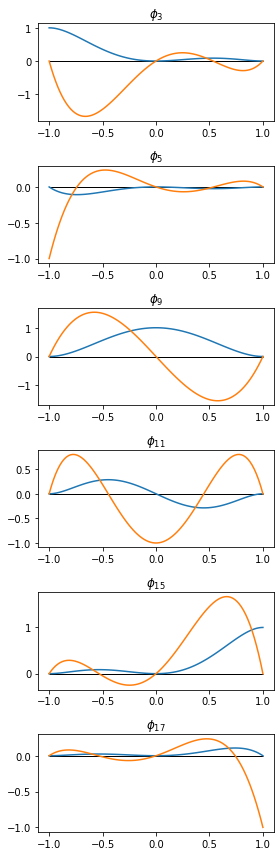

In [41]:
w = 4
h = 2 * len(inds)
fig = plt.figure(figsize=(w, h))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(len(inds), 1)

xdata = np.linspace(-1, 1, 100)

for i, ind in enumerate(inds):
    ax = fig.add_subplot(gs[i])
    label = '$' + module_data[ind]['symbol'] + '$'
    ax.set_title(label)
    # fnc
    fnc = module_data[ind][0].subs({'L': 2})
    shp = sy.lambdify('x', fnc, 'numpy')
    fdata = list(map(shp, xdata))
    ax.plot(xdata, fdata)
    # first derivative
    fnc = module_data[ind][1].subs({'L': 2})
    shp = sy.lambdify('x', fnc, 'numpy')
    fdata = list(map(shp, xdata))
    ax.plot(xdata, fdata)
    #
    ax.hlines(y=0, xmin=-1, xmax=1, colors='k', zorder=-10, lw=1.0)

fig.tight_layout()


## **Code Generation**

In [42]:
import autopep8
def fix_code(code): return autopep8.fix_code(code, options={'aggressive': 2})


def fix_code(code): return code


In [43]:
shp0 = [pycode(module_data[i+1][0]) for i in range(N*6)]
shp1 = [pycode(module_data[i+1][1]) for i in range(N*6)]
shp2 = [pycode(module_data[i+1][2]) for i in range(N*6)]
shp3 = [pycode(module_data[i+1][3]) for i in range(N*6)]


In [44]:
f = open(src_path + '.py', "w", encoding='utf-8')
f.write("# -*- coding: utf-8 -*-\n")
f.write("import numpy as np\n")
f.write("from numpy import ndarray\n")
f.write("from numba import njit, prange\n")
f.write("__cache = True\n\n\n")

tmpl = ",\n".join(["    {}" for _ in range(6)])
tmpl = "[\n" + tmpl + "\n]"
layout_raw = [tmpl for _ in range(N)]
layout = ",\n".join(layout_raw)

# shape function values
f.write("@njit(nogil={}, cache=__cache)\n".format(True))
f.write("""def shape_function_values(x, L):""")
impl = \
    """
    \"\"\"
    Evaluates the shape functions at a point x in the range [-1, 1].
    \"\"\"
    return np.array([
            {}
        ])
    """.format(layout.format(*shp0))
f.write(fix_code(impl))
f.write("\n\n")

# shape function derivatives d/dx
f.write("@njit(nogil={}, cache=__cache)\n".format(True))
f.write("""def shape_function_derivatives_1(x, L):""")
impl = \
    """
    \"\"\"
    Evaluates the first derivatives of the shape 
    functions at a point x in the range [-1, 1]. 
    \"\"\"
    return np.array([
            {}
        ])
    """.format(layout.format(*shp1))
f.write(fix_code(impl))
f.write("\n\n")

# shape function derivatives d2/dx2
f.write("@njit(nogil={}, cache=__cache)\n".format(True))
f.write("""def shape_function_derivatives_2(x, L):""")
impl = \
    """
    \"\"\"
    Evaluates the second derivatives of the shape 
    functions at a point x in the range [-1, 1].
    \"\"\"
    return np.array([
            {}
        ])
    """.format(layout.format(*shp2))
f.write(fix_code(impl))
f.write("\n\n")

# shape function derivatives d3/dx3
f.write("@njit(nogil={}, cache=__cache)\n".format(True))
f.write("""def shape_function_derivatives_3(x, L):""")
impl = \
    """
    \"\"\"
    Evaluates the third derivatives of the shape 
    functions at a point x in the range [-1, 1]. 
    \"\"\"
    return np.array([
            {}
        ])
    """.format(layout.format(*shp3))
f.write(fix_code(impl))
f.write("\n\n")

# --------------

f.write("@njit(nogil=True, parallel=True, cache=__cache)\n")
f.write("""def shape_function_values_bulk(x: ndarray, L: ndarray):""")
impl = \
    """
    \"\"\"
    Evaluates the shape functions at several points
    in the range [-1, 1].
    
    Parameters
    ----------
    x : 1d numpy float array
        The points of interest in the range [-1, -1]
    
    Returns
    -------
    numpy float array of shape (nE, nP, nNE, nDOF=6) 
    \"\"\"
    nP = x.shape[0]
    nE = L.shape[0]
    res = np.zeros((nE, nP, {}, 6), dtype=x.dtype)
    for iE in prange(nE):
        for iP in prange(nP):
            res[iE, iP] = shape_function_values(x[iP], L[iE])
    return res
    """.format(N)
f.write(fix_code(impl))
f.write("\n\n")

f.write("@njit(nogil=True, cache=__cache)\n")
f.write("""def shape_function_derivatives(x, L):""")
impl = \
    """
    \"\"\"
    Evaluates the derivatives of the shape 
    functions at a point x in the range [-1, 1].
    
    Parameters
    ----------
    x : float
        The point of interest in the range [-1, -1]
    
    djac : float
        Determinant of the Jacobi matrix of local-global transformation
        between the master elment and the actual element. 
        Default is 1.0.
    
    Returns
    -------
    numpy float array of shape (nNE, nDOF=6, 3) 
    \"\"\"
    res = np.zeros(({}, 6, 3))
    res[:, :, 0] = shape_function_derivatives_1(x, L)
    res[:, :, 1] = shape_function_derivatives_2(x, L)
    res[:, :, 2] = shape_function_derivatives_3(x, L)
    return res
    """.format(N)
f.write(fix_code(impl))
f.write("\n\n")

f.write("@njit(nogil=True, parallel=True, cache=__cache)\n")
f.write("""def shape_function_derivatives_bulk(x: ndarray, L: ndarray):""")
impl = \
    """
    \"\"\"
    Evaluates the derivatives of the shape 
    functions at several points in the range [-1, 1].
    
    Returns
    -------
    dshp (nE, nP, nNE, nDOF=6, 3)
    \"\"\"
    nP = x.shape[0]
    nE = L.shape[0]
    res = np.zeros((nE, nP, {}, 6, 3), dtype=x.dtype)
    for iE in prange(nE):
        for iP in prange(nP):
            res[iE, iP] = shape_function_derivatives(x[iP], L[iE])
    return res
    """.format(N)
f.write(fix_code(impl))
f.write("\n\n")

f.close()


In [45]:
import subprocess
cmd = ['autopep8', '--in-place', '--aggressive',
       '--aggressive', src_path + '.py']
result = subprocess.run(cmd, capture_output=True, text=True)
print("stdout:", result.stdout)
print("stderr:", result.stderr)


stdout: 
stderr: 


## Plotting

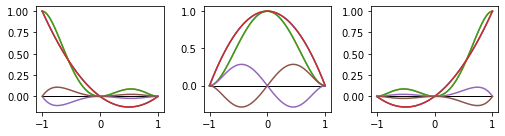

In [46]:
fig = plt.figure(figsize=(7.12, 2))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, N)

xdata = np.linspace(-1, 1, 100)

for i in range(N):
    ax = fig.add_subplot(gs[i])
    for j in range(6):
        c = 6 * i + j
        fnc = module_data[c+1][0].subs({'L': 2})
        shp_ = sy.lambdify('x', fnc, 'numpy')
        fdata = list(map(shp_, xdata))
        label = '$' + module_data[c+1]['symbol'] + '$'
        ax.plot(xdata, fdata, label=label)
        #
        ax.hlines(y=0, xmin=-1, xmax=1, colors='k', zorder=-10, lw=1.0)

# fig.legend()
fig.tight_layout()


In [47]:
fig.savefig(pgf_path, format='pgf')


## Documentation

In [48]:
import pylatex as pltx
from pylatex import Section, Subsection, Command, NoEscape, Package, NewPage
from sigmaepsilon.solid.fourier.latex import expr_to_ltx, expr_to_ltx_breqn


In [49]:
geometry_options = {
    "tmargin": "1.5cm",
    "lmargin": "1.5cm",
    "rmargin": "1.5cm"
}
doc = pltx.Document(geometry_options=geometry_options)

r"""
Tools related to displaying math. It's a bit like the numpy of latex, must
have stuff.
"""
doc.packages.append(Package('amsmath'))

r"""
Sympy uses the 'operatorname' command frequently to print symbols.
"""
doc.packages.append(Package('amsopn'))

r"""
To automatically break long equations into multiple lines.
"""
doc.packages.append(Package('breqn'))

r"""
mathtools provides us with the \coloneqq command, for defining equality
symbol ':='
"""
doc.packages.append(Package('mathtools'))


r"""
To include pgf files
"""
doc.packages.append(Package('pgf'))

r"""
Misc
"""
doc.packages.append(Package('enumitem'))  # to customize enumerations
doc.packages.append(Package('xcolor'))  # colors
doc.packages.append(Package('lmodern'))  # high quality fonts

title = "Bernoulli 2."
doc.preamble.append(Command('title', title))
doc.preamble.append(Command('author', 'BB'))
doc.preamble.append(Command('date', NoEscape(r'\today')))
doc.append(NoEscape(r'\maketitle'))
# doc.append(NoEscape(r'\tableofcontents'))
doc.append(NewPage())

sections = {}


In [50]:
sections['Shape functions'] = doc.create(Section('Shape functions'))


In [51]:
def ltx(expr): return sy.latex(expr, mul_symbol="times")

with sections['Shape functions']:
    for i, expr in enumerate(shp0):
        fnc = latex(sy.symbols('\phi_{}'.format(i+1))) + '(x)'
        doc.append(expr_to_ltx(fnc, ltx(expr)))

    _path = r"\input<{}>".format(pgf_tmpl.format(
        N)).replace('<', '{').replace('>', '}')
    doc.append(NoEscape(_path))


In [52]:
#doc.generate_pdf(doc_path, clean_tex=False, compiler='pdfLaTeX')
